In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import sys
from tqdm import tqdm
from datetime import datetime
import csv

# Add src to path
sys.path.append('..')
from src.data import create_dataloaders, denormalize

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"Device: {'mps' if torch.backends.mps.is_available() else 'cpu'}")


PyTorch version: 2.9.0
MPS available: True
Device: mps


In [3]:

CONFIG = {
    'experiment_name': 'baseline_resnet50',
    'model_name': 'resnet50',
    'num_classes': 37,
    'pretrained': True,
    
    'training': {
        'epochs': 30,
        'batch_size': 32,
        'num_workers': 4,
        'learning_rate': 3e-4,
        'weight_decay': 0.01,
        'optimizer': 'AdamW',
    },
    
    'scheduler': {
        'type': 'cosine',
        'T_max': 30,  # epochs
    },
    
    'data': {
        'image_size': 224,
        'data_root' : os.path.expanduser('~/datasets/oxford-iiit-pet'),
        'split_metadata_path': '../data/processed/split_metadata.json',
    },
    
    'device': 'mps' if torch.backends.mps.is_available() else 'cpu',
    
    'checkpoint': {
        'save_every': 5,  # Save every 5 epochs
        'save_dir': '../models/checkpoints/baseline',
    },
}

# Create checkpoint directory
os.makedirs(CONFIG['checkpoint']['save_dir'], exist_ok=True)

# Save config
config_path = '../experiments/configs/baseline_config.json'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
for key, value in CONFIG.items():
    print(f"{key}: {value}")
print("="*60)

device = torch.device(CONFIG['device'])
print(f"\nUsing device: {device}")


TRAINING CONFIGURATION
experiment_name: baseline_resnet50
model_name: resnet50
num_classes: 37
pretrained: True
training: {'epochs': 30, 'batch_size': 32, 'num_workers': 4, 'learning_rate': 0.0003, 'weight_decay': 0.01, 'optimizer': 'AdamW'}
scheduler: {'type': 'cosine', 'T_max': 30}
data: {'image_size': 224, 'data_root': '/Users/nidhimithiya/datasets/oxford-iiit-pet', 'split_metadata_path': '../data/processed/split_metadata.json'}
device: mps
checkpoint: {'save_every': 5, 'save_dir': '../models/checkpoints/baseline'}

Using device: mps


In [4]:
print("Loading dataset and creating dataloaders...")

train_loader, val_loader, dataset = create_dataloaders(
    data_root=CONFIG['data']['data_root'],
    split_metadata_path=CONFIG['data']['split_metadata_path'],
    batch_size=CONFIG['training']['batch_size'],
    num_workers=CONFIG['training']['num_workers'],
    img_size=CONFIG['data']['image_size'],
    pin_memory=False  # MPS doesn't support pin_memory
)

print(f"✓ Train loader: {len(train_loader)} batches")
print(f"✓ Val loader: {len(val_loader)} batches")


Loading dataset and creating dataloaders...
✓ Loaded split from ../data/processed/split_metadata.json
✓ Train dataset: 2944 samples
✓ Val dataset: 736 samples
✓ Train loader: 92 batches
✓ Val loader: 23 batches
✓ Train loader: 92 batches
✓ Val loader: 23 batches


In [5]:
# Load pretrained ResNet-50
import torchvision.models as models

print("Loading ResNet-50 (ImageNet pretrained)...")

model = models.resnet50(weights='DEFAULT')

# Modify final layer for 37 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, CONFIG['num_classes'])

# Move to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ ResNet-50 loaded")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {device}")


Loading ResNet-50 (ImageNet pretrained)...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/nidhimithiya/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:13<00:00, 7.55MB/s]


✓ ResNet-50 loaded
  Total parameters: 23,583,845
  Trainable parameters: 23,583,845
  Device: mps


In [6]:
# Optimizer
if CONFIG['training']['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['training']['learning_rate'],
        weight_decay=CONFIG['training']['weight_decay']
    )
elif CONFIG['training']['optimizer'] == 'Adam':
    optimizer = optim.Adam(
        model.parameters(),
        lr=CONFIG['training']['learning_rate'],
        weight_decay=CONFIG['training']['weight_decay']
    )

# Learning rate scheduler
if CONFIG['scheduler']['type'] == 'cosine':
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=CONFIG['scheduler']['T_max'],
        eta_min=1e-6
    )

# Loss function
criterion = nn.CrossEntropyLoss()

print("✓ Optimizer: AdamW")
print(f"  Learning rate: {CONFIG['training']['learning_rate']}")
print(f"  Weight decay: {CONFIG['training']['weight_decay']}")
print("✓ Scheduler: Cosine Annealing")
print(f"  T_max: {CONFIG['scheduler']['T_max']} epochs")
print("✓ Loss: CrossEntropyLoss")


✓ Optimizer: AdamW
  Learning rate: 0.0003
  Weight decay: 0.01
✓ Scheduler: Cosine Annealing
  T_max: 30 epochs
✓ Loss: CrossEntropyLoss


In [7]:
def train_epoch(model, train_loader, optimizer, criterion, device, epoch):
    """Train for one epoch"""
    model.train()
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{CONFIG["training"]["epochs"]} [TRAIN]')
    
    for batch_idx, batch in enumerate(pbar):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        accuracy = 100 * correct / total
        avg_loss = total_loss / (batch_idx + 1)
        pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{accuracy:.2f}%'})
    
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device, epoch):
    """Validate for one epoch"""
    model.eval()
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{CONFIG["training"]["epochs"]} [VAL]')
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(pbar):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            accuracy = 100 * correct / total
            avg_loss = total_loss / (batch_idx + 1)
            pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{accuracy:.2f}%'})
    
    epoch_loss = total_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


print("✓ Training and validation functions defined")


✓ Training and validation functions defined


In [9]:
# Initialize tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

best_val_acc = 0.0
start_time = datetime.now()

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Start time: {start_time}")
print("="*60 + "\n")

# Training loop
for epoch in range(CONFIG['training']['epochs']):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, epoch
    )
    
    # Validate
    val_loss, val_acc = validate_epoch(
        model, val_loader, criterion, device, epoch
    )
    
    # Learning rate step
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{CONFIG['training']['epochs']}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  LR: {current_lr:.2e}")
    
    # Save checkpoint
    if (epoch + 1) % CONFIG['checkpoint']['save_every'] == 0:
        checkpoint_path = os.path.join(
            CONFIG['checkpoint']['save_dir'],
            f'resnet50_epoch_{epoch+1}.pth'
        )
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'config': CONFIG
        }, checkpoint_path)
        print(f"  ✓ Checkpoint saved: {checkpoint_path}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_checkpoint_path = os.path.join(
            CONFIG['checkpoint']['save_dir'],
            'resnet50_best.pth'
        )
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'config': CONFIG,
            'best_val_acc': best_val_acc
        }, best_checkpoint_path)
        print(f"  ✓ Best model saved: {best_checkpoint_path}")

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"End time: {end_time}")
print(f"Total time: {total_time/3600:.1f} hours ({total_time/60:.0f} minutes)")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print("="*60)




STARTING TRAINING
Start time: 2025-11-02 10:00:24.582804



Epoch 1/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(90365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 1/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(90450) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 1/30
  Train Loss: 0.3986 | Train Acc: 87.60%
  Val Loss:   0.5057 | Val Acc:   83.97%
  LR: 2.97e-04
  ✓ Best model saved: ../models/checkpoints/baseline/resnet50_best.pth


Epoch 2/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(90475) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 2/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(90885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 2/30
  Train Loss: 0.2780 | Train Acc: 91.54%
  Val Loss:   0.4244 | Val Acc:   88.32%
  LR: 2.93e-04
  ✓ Best model saved: ../models/checkpoints/baseline/resnet50_best.pth


Epoch 3/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(90899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 3/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(91422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 3/30
  Train Loss: 0.1954 | Train Acc: 94.46%
  Val Loss:   0.3797 | Val Acc:   88.59%
  LR: 2.87e-04
  ✓ Best model saved: ../models/checkpoints/baseline/resnet50_best.pth


Epoch 4/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(91461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 4/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(92166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 4/30
  Train Loss: 0.1757 | Train Acc: 94.46%
  Val Loss:   0.4557 | Val Acc:   86.28%
  LR: 2.80e-04


Epoch 5/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(92219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 5/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(92605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 5/30
  Train Loss: 0.1019 | Train Acc: 97.32%
  Val Loss:   0.4370 | Val Acc:   87.64%
  LR: 2.71e-04
  ✓ Checkpoint saved: ../models/checkpoints/baseline/resnet50_epoch_5.pth


Epoch 6/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(92733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 6/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(93011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93027) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93033) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93045) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 6/30
  Train Loss: 0.1214 | Train Acc: 96.30%
  Val Loss:   0.3696 | Val Acc:   87.77%
  LR: 2.62e-04


Epoch 7/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(93089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 7/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(93354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 7/30
  Train Loss: 0.1148 | Train Acc: 96.43%
  Val Loss:   0.4044 | Val Acc:   88.45%
  LR: 2.51e-04


Epoch 8/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(93366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 8/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(93644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93666) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93681) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 8/30
  Train Loss: 0.0518 | Train Acc: 98.81%
  Val Loss:   0.4788 | Val Acc:   87.64%
  LR: 2.38e-04


Epoch 9/30 [TRAIN]:   0%|                                                          | 0/92 [00:00<?, ?it/s]Python(93775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93778) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93779) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 9/30 [VAL]:   0%|                                                            | 0/23 [00:00<?, ?it/s]Python(94372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94377) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94378) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 9/30
  Train Loss: 0.0569 | Train Acc: 98.54%
  Val Loss:   0.3576 | Val Acc:   89.40%
  LR: 2.25e-04
  ✓ Best model saved: ../models/checkpoints/baseline/resnet50_best.pth


Epoch 10/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(94486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 10/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(94901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 10/30
  Train Loss: 0.0400 | Train Acc: 98.61%
  Val Loss:   0.3762 | Val Acc:   90.76%
  LR: 2.11e-04
  ✓ Checkpoint saved: ../models/checkpoints/baseline/resnet50_epoch_10.pth
  ✓ Best model saved: ../models/checkpoints/baseline/resnet50_best.pth


Epoch 11/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(94971) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94974) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94977) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94979) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 11/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(95287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95290) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95291) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 11/30
  Train Loss: 0.0375 | Train Acc: 98.81%
  Val Loss:   0.4117 | Val Acc:   88.72%
  LR: 1.97e-04


Epoch 12/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(95362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 12/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(95811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 12/30
  Train Loss: 0.0413 | Train Acc: 98.71%
  Val Loss:   0.4247 | Val Acc:   88.86%
  LR: 1.82e-04


Epoch 13/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(95863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95876) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(95885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 13/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(96333) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 13/30
  Train Loss: 0.0243 | Train Acc: 99.25%
  Val Loss:   0.3822 | Val Acc:   89.13%
  LR: 1.66e-04


Epoch 14/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(96447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 14/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(97007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 14/30
  Train Loss: 0.0295 | Train Acc: 99.39%
  Val Loss:   0.4057 | Val Acc:   90.49%
  LR: 1.50e-04


Epoch 15/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(97029) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97032) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97033) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97034) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 15/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(97432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 15/30
  Train Loss: 0.0196 | Train Acc: 99.49%
  Val Loss:   0.3554 | Val Acc:   91.17%
  LR: 1.35e-04
  ✓ Checkpoint saved: ../models/checkpoints/baseline/resnet50_epoch_15.pth
  ✓ Best model saved: ../models/checkpoints/baseline/resnet50_best.pth


Epoch 16/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(97498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 16/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(97995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(97999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 16/30
  Train Loss: 0.0157 | Train Acc: 99.63%
  Val Loss:   0.3704 | Val Acc:   91.17%
  LR: 1.19e-04


Epoch 17/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(98031) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98034) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98035) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98037) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 17/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(98419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 17/30
  Train Loss: 0.0114 | Train Acc: 99.73%
  Val Loss:   0.3560 | Val Acc:   91.44%
  LR: 1.04e-04
  ✓ Best model saved: ../models/checkpoints/baseline/resnet50_best.pth


Epoch 18/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(98450) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(98456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 18/30 [VAL]:   0%|                                                           | 0/23 [00:00<?, ?it/s]Python(99380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99401) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoc


Epoch 18/30
  Train Loss: 0.0131 | Train Acc: 99.69%
  Val Loss:   0.3414 | Val Acc:   92.39%
  LR: 8.97e-05
  ✓ Best model saved: ../models/checkpoints/baseline/resnet50_best.pth


Epoch 19/30 [TRAIN]:   0%|                                                         | 0/92 [00:00<?, ?it/s]Python(99480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 19/30 [TRAIN]:  14%|███▏                   | 13/92 [02:18<11:51,  9.00s/it, loss=0.0078, acc=99.76%]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11ceedda0>
Traceback (most recent call last):
  File "/Users/nidhimithiya/Desktop/Spurious_correlation/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/Users/nidhimithiya/Desktop/Spurious_correlation/.venv/lib/python3.13/site-packages/torch/

KeyboardInterrupt: 

In [10]:
# Save history to CSV
history_csv_path = '../experiments/results/metrics/baseline_training_history.csv'
os.makedirs(os.path.dirname(history_csv_path), exist_ok=True)

with open(history_csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr'])
    
    for epoch in range(len(history['train_loss'])):
        writer.writerow([
            epoch + 1,
            history['train_loss'][epoch],
            history['train_acc'][epoch],
            history['val_loss'][epoch],
            history['val_acc'][epoch],
            history['learning_rate'][epoch]
        ])

print(f"✓ Training history saved to: {history_csv_path}")

# Save history to JSON
history_json_path = '../experiments/results/metrics/baseline_training_history.json'
with open(history_json_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"✓ Training history saved to: {history_json_path}")


✓ Training history saved to: ../experiments/results/metrics/baseline_training_history.csv
✓ Training history saved to: ../experiments/results/metrics/baseline_training_history.json


✓ Training curves saved to: ../experiments/results/plots/baseline_training_curves.png


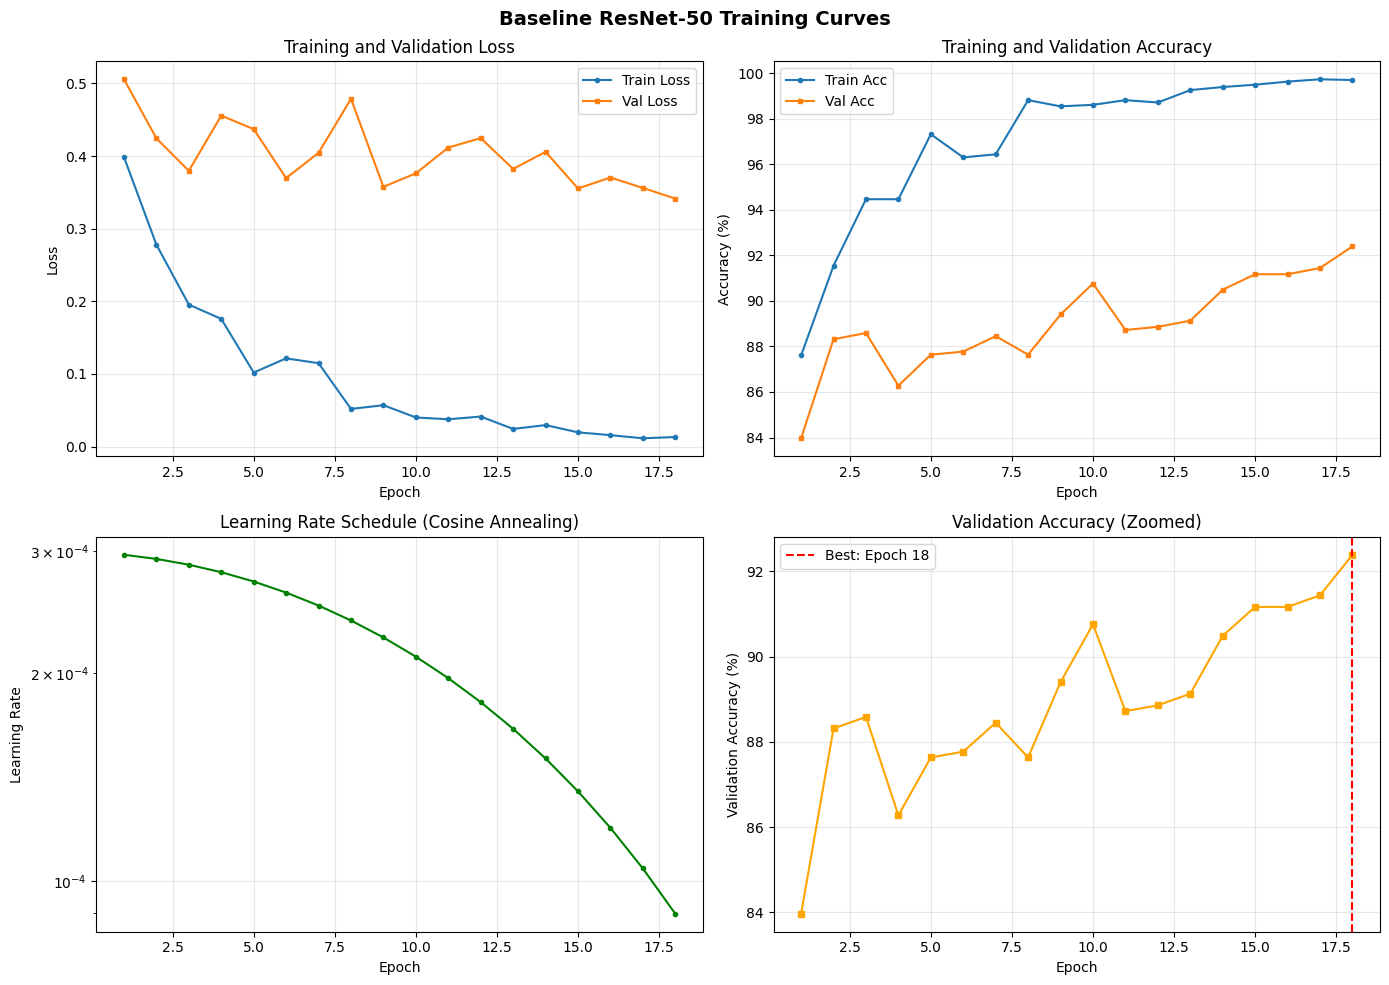

In [12]:
# Create comprehensive training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss plot
axes[0, 0].plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0, 0].plot(epochs_range, history['val_loss'], label='Val Loss', marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(epochs_range, history['train_acc'], label='Train Acc', marker='o', markersize=3)
axes[0, 1].plot(epochs_range, history['val_acc'], label='Val Acc', marker='s', markersize=3)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate plot
axes[1, 0].plot(epochs_range, history['learning_rate'], marker='o', markersize=3, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule (Cosine Annealing)')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Validation accuracy zoomed
best_epoch = np.argmax(history['val_acc']) + 1
axes[1, 1].plot(epochs_range, history['val_acc'], marker='s', markersize=4, color='orange')
axes[1, 1].axvline(x=best_epoch, color='red', linestyle='--', label=f'Best: Epoch {best_epoch}')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Accuracy (%)')
axes[1, 1].set_title('Validation Accuracy (Zoomed)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Baseline ResNet-50 Training Curves', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save plot
plot_path = '../experiments/results/plots/baseline_training_curves.png'
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Training curves saved to: {plot_path}")

plt.show()


In [14]:

summary = f"""
MODEL: ResNet-50 (ImageNet pretrained)
DATASET: Oxford-IIIT Pet (37 classes)
  Training samples: {len(train_loader.dataset)}
  Validation samples: {len(val_loader.dataset)}

TRAINING CONFIGURATION:
  Epochs: {CONFIG['training']['epochs']}
  Batch size: {CONFIG['training']['batch_size']}
  Learning rate: {CONFIG['training']['learning_rate']}
  Optimizer: {CONFIG['training']['optimizer']}
  Weight decay: {CONFIG['training']['weight_decay']}
  Scheduler: {CONFIG['scheduler']['type']} (T_max={CONFIG['scheduler']['T_max']})
  Loss: CrossEntropyLoss

RESULTS:
  Best validation accuracy: {best_val_acc:.2f}%
  Best epoch: {np.argmax(history['val_acc']) + 1}
  Final train loss: {history['train_loss'][-1]:.4f}
  Final val loss: {history['val_loss'][-1]:.4f}

FILES SAVED:
  ✓ Best model: ../models/checkpoints/baseline/resnet50_best.pth
  ✓ Checkpoints: ../models/checkpoints/baseline/resnet50_epoch_*.pth
  ✓ Training history: ../experiments/results/metrics/baseline_training_history.csv
  ✓ Training history: ../experiments/results/metrics/baseline_training_history.json
  ✓ Training curves: ../experiments/results/plots/baseline_training_curves.png
  ✓ Config: ../experiments/configs/baseline_config.json

NEXT STEPS (Day 4):
  1. Evaluate baseline model on validation set
  2. Generate Grad-CAM saliency maps
  3. Compute FAR (Foreground Attention Ratio)
  4. Evaluate on counterfactual images
  5. Compute ∆Acc (accuracy drop with background swap)
"""

print(summary)



MODEL: ResNet-50 (ImageNet pretrained)
DATASET: Oxford-IIIT Pet (37 classes)
  Training samples: 2944
  Validation samples: 736

TRAINING CONFIGURATION:
  Epochs: 30
  Batch size: 32
  Learning rate: 0.0003
  Optimizer: AdamW
  Weight decay: 0.01
  Scheduler: cosine (T_max=30)
  Loss: CrossEntropyLoss

RESULTS:
  Best validation accuracy: 92.39%
  Best epoch: 18
  Final train loss: 0.0131
  Final val loss: 0.3414

FILES SAVED:
  ✓ Best model: ../models/checkpoints/baseline/resnet50_best.pth
  ✓ Checkpoints: ../models/checkpoints/baseline/resnet50_epoch_*.pth
  ✓ Training history: ../experiments/results/metrics/baseline_training_history.csv
  ✓ Training history: ../experiments/results/metrics/baseline_training_history.json
  ✓ Training curves: ../experiments/results/plots/baseline_training_curves.png
  ✓ Config: ../experiments/configs/baseline_config.json

NEXT STEPS (Day 4):
  1. Evaluate baseline model on validation set
  2. Generate Grad-CAM saliency maps
  3. Compute FAR (Foregroun